## DEMs coregistration demo
### Note: The data for co-registration should be utm projected.


In [1]:
import os
root_proj = '/Users/luo/OneDrive/GitHub/Glacier-in-RGI1305'
os.chdir(root_proj)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.imgShow import imgShow
from utils.crop_to_extent import crop_to_extent
from utils.raster_vec import vec2mask
import pybob.coreg_tools as ct
from pybob.GeoImg import GeoImg


In [3]:
path_srtm = 'data/dem-data/srtm-c/SRTMGL1_E_wkunlun_utm.tif'         # master dem
path_tandem = 'data/dem-data/tandem-x/dems_mosaic_wkunlun_utm.tif'   # slave dem
path_l8img = 'data/rsimg/l8_kunlun_20200914.tif'
path_water_jrc = 'data/water_jrc/wkl_water_jrc_utm.tif'   # jrc water map for water mask
path_rgi_1305 = 'data/rgi60-wkunlun/rgi60_1305.gpkg'      # rgi glacier data for glacier mask


In [4]:
srtm, srtm_info = readTiff(path_srtm)  # master dem
tandem, tandem_info = readTiff(path_tandem)  # slave dem
l8_img, l8_img_info = readTiff(path_l8img) 
water_jrc, water_jrc_info = readTiff(path_water_jrc)
print('srtm shape:',   srtm.shape, 'extent:', srtm_info['geoextent'])
print('tandem shape:', tandem.shape, 'extent',  tandem_info['geoextent'])
print('water_jrc shape:', water_jrc.shape, 'extent',  water_jrc_info['geoextent'])


srtm shape: (3507, 5552) extent: (419416.44565371965, 585976.4456537196, 3862741.200990109, 3967951.200990109)
tandem shape: (1323, 2095) extent (419416.4456505731, 586024.4012380684, 3862737.9219186474, 3967951.442320679)
water_jrc shape: (4091, 6476) extent (419403.8461468267, 585958.2539156231, 3862780.053972968, 3967995.3229942997)


In [5]:
### Image alignment for the tandem data.
tandem_align = crop_to_extent(path_img=path_tandem, \
                          extent=srtm_info['geoextent'], size_target=srtm.shape)
print('aligned tandem shape:', tandem_align.shape)


aligned tandem shape: (3507, 5552)


### Check dem image

Text(0.5, 1.0, 'aligned tandem (slave)')

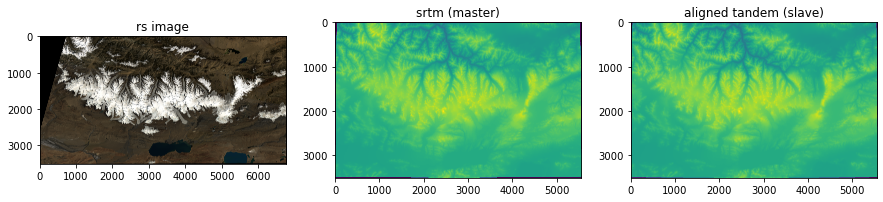

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); imgShow(l8_img); plt.title('rs image')
plt.subplot(1,3,2); plt.imshow(srtm, vmin=2000, vmax=7000); plt.title('srtm (master)')
plt.subplot(1,3,3); plt.imshow(tandem_align, vmin=2000, vmax=7000); plt.title('aligned tandem (slave)')


### **1. Generate mask image.**

(3507, 5552)


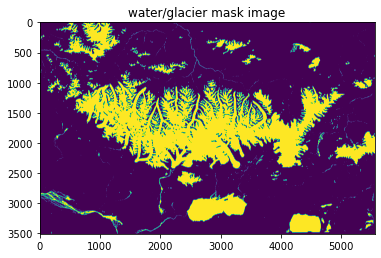

In [7]:
### -- 2.1. water mask
water_jrc_crop = crop_to_extent(path_img=path_water_jrc, \
                                  extent=srtm_info['geoextent'], size_target=srtm.shape)
water_jrc_crop = np.ma.masked_where(water_jrc_crop>50, water_jrc_crop)
### -- 2.2. glacier mask
rgi60_mask = vec2mask(path_vec=path_rgi_1305, path_raster=path_srtm, path_save=None)
rgi60_mask = np.ma.masked_equal(rgi60_mask, 1)
### -- 2.3 merge the water and glacier masks
mask = np.logical_or.reduce([water_jrc_crop.mask, rgi60_mask.mask])
plt.imshow(mask); plt.title('water/glacier mask image')
print(mask.shape)


### **2. Co-registration to srtm-c dem by using open-source pybob code.**
##### Reference: Nuth and Kääb (2011) (https://www.the-cryosphere.net/5/271/2011/tc-5-271-2011.html)


In [8]:
srtm_geo = GeoImg(path_srtm)   # master dem
tandem_geo = srtm_geo.copy(new_raster=tandem_align)
slope_geo = ct.get_slope(srtm_geo)    # calculate slope from master DEM, scale is 111120 if using wgs84 projection
aspect_geo = ct.get_aspect(srtm_geo)  # calculate aspect from master DEM
print(srtm_geo.img.shape, tandem_geo.img.shape)


(3507, 5552) (3507, 5552)


In [9]:
init_dh_geo = tandem_geo.copy(new_raster=tandem_geo.img-srtm_geo.img)  # initial dem difference (a new GeoImg dataset)


### **2.1. co-registration and obtain the adjust values**

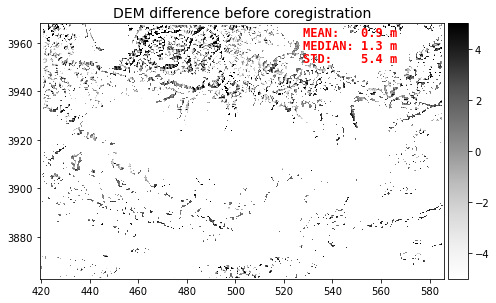

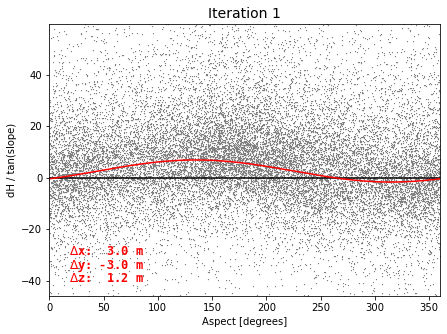

In [11]:
## --- 1. copy the slave_dem as the medium processing dem
tandem_proc = tandem_geo.copy()   # make a copy of the slave DEM
## --- 2. pre-processing: data mask by provided mask data and the calculated outlier values; 
## xdata->masked aspect, ydata->masked dH, sdata->masked tan(a)
dH, xdata, ydata, sdata = ct.preprocess(stable_mask=mask, slope=slope_geo.img, \
                                    aspect=aspect_geo.img, master=srtm_geo, slave=tandem_proc)
fig = ct.false_hillshade(dH, 'DEM difference before coregistration', clim=(-5, 5)) 
## --- 3. initial the shift values (will be updated during this process).
## --- 4. co-registration, obtain the adjust values.
xadj, yadj, zadj = ct.coreg_fitting(xdata, ydata, sdata, 'Iteration 1')


### **2.2. Rectify the original image with obtained shift values**

In [12]:
## update the shift values
x_shift = y_shift = z_shift = 0
x_shift += xadj; y_shift += yadj; z_shift += zadj
print('shift values (x,y,z):', x_shift, y_shift, z_shift)
## --- 1. rectify the x and y.  
tandem_proc.shift(xadj, yadj)        # rectify the slave dem in terms of x and y.
tandem_proc = tandem_proc.reproject(srtm_geo)   # re-align the grid of the slave DEMs after shifting
## --- 2. rectify the z. 
tandem_proc = tandem_proc.copy(new_raster=tandem_proc.img + zadj) # shift the DEM in the z direction
final_dh_geo = tandem_geo.copy(new_raster=tandem_proc.img - srtm_geo.img)



shift values (x,y,z): 3.0381334764306382 -3.039058643914944 1.1738292718830416


### **2.3. Co-registration with more iterations**

In [13]:
def dems_coreg(master_geo, slave_geo, mask_img, iteration=10):
  slope_geo = ct.get_slope(master_geo)    # calculate slope from master DEM
  aspect_geo = ct.get_aspect(master_geo)  # calculate aspect from master DEM
  slave_proc = slave_geo.copy()           # make a copy of the slave DEM
  for i in range(iteration):
    x_shift = y_shift = z_shift = 0
    dH, xdata, ydata, sdata = ct.preprocess(stable_mask=mask_img, slope=slope_geo.img, \
                                      aspect=aspect_geo.img, master=master_geo, slave=slave_proc)    
    ## --- 1. calculate shift values.
    i_iter = 'Iteration '+str(i)
    xadj, yadj, zadj = ct.coreg_fitting(xdata, ydata, sdata, i_iter, plot=False)
    x_shift += xadj; y_shift += yadj; z_shift += zadj  # update shift value
    ## --- 2. rectify original dem.
    slave_proc.shift(xadj, yadj)                    # rectify the slave dem in terms of x and y.
    slave_proc = slave_proc.reproject(master_geo)   # re-align the grid of the slave DEMs after shifting
    slave_proc = slave_proc.copy(new_raster=slave_proc.img + zadj)   # shift the DEM in the z direction
    print('shift values in iteration '+str(i)+' (x,y,z):', x_shift, y_shift, z_shift)  
  return slave_proc

tandem_coreg = dems_coreg(master_geo=srtm_geo, slave_geo=tandem_geo, mask_img=mask, iteration=10)
init_dh_geo = tandem_geo.copy(new_raster=tandem_geo.img-srtm_geo.img)  # initial dem difference (GeoImg dataset)
final_dh_geo = tandem_geo.copy(new_raster=tandem_coreg.img-srtm_geo.img)  # initial dem difference


shift values in iteration 0 (x,y,z): 3.086826484301052 -3.4302253581665103 1.2375578399656502
shift values in iteration 1 (x,y,z): 0.3078200682936388 -0.14352624005213052 -0.049469864415575146
shift values in iteration 2 (x,y,z): 0.049933608038714695 0.1657092274843274 0.048265138731820915
shift values in iteration 3 (x,y,z): -0.052875947456714714 -0.10146845626810419 -0.04805867509497533
shift values in iteration 4 (x,y,z): 0.2035946531382787 -0.035162008263319146 0.005104704043471281
shift values in iteration 5 (x,y,z): 0.32164326099987794 0.06764316069074304 0.013817387489440272
shift values in iteration 6 (x,y,z): -0.10603275481660583 0.306496790019171 0.006532819981278867
shift values in iteration 7 (x,y,z): -0.13930392177187972 -0.38585162475927354 -0.028815656054925455
shift values in iteration 8 (x,y,z): -0.035097394999452046 -0.04861996835982455 0.02750472131483567
shift values in iteration 9 (x,y,z): 0.031617633850804634 -0.044204663165592614 0.011223597622533863


### **Visualize the dems difference before and affter co-registration**

Text(0.5, 1.0, 'after co-registration')

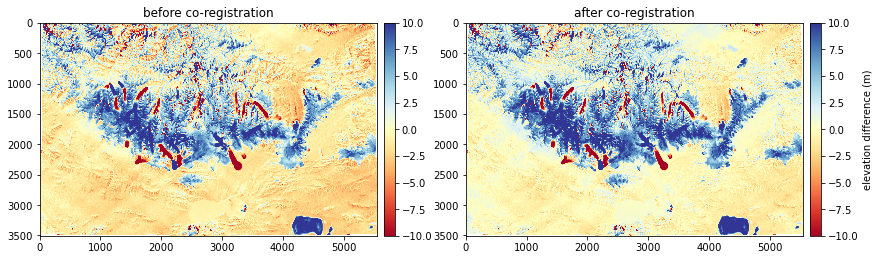

In [14]:
fig1 = plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.imshow(init_dh_geo.img, vmin=-10, vmax=10, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
# cb.set_label('elevation difference (m)')
plt.title('before co-registration')

plt.subplot(1,2,2)
plt.imshow(final_dh_geo.img, vmin=-10, vmax=10, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
cb.set_label('elevation difference (m)')
plt.title('after co-registration')

